<a href="https://colab.research.google.com/github/PreetamMT/COMP9517_Final_Assignment_Code/blob/main/Hybrid_SVM_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Color Test: 100%|██████████| 2400/2400 [00:11<00:00, 217.72it/s]



>>> Balanced Test Accuracy: 0.9596 (train+eval 11.6s)
>>> Imbalanced Test Accuracy: 0.9025 (train+eval 5.2s)

=== Balanced Dataset Classification Report ===
              precision    recall  f1-score   support

 Agriculture       0.98      0.98      0.98       160
     Airport       0.90      0.96      0.93       160
       Beach       0.96      0.98      0.97       160
        City       0.97      0.97      0.97       160
      Desert       0.98      0.99      0.98       160
      Forest       0.96      0.99      0.98       160
   Grassland       0.97      0.94      0.96       160
     Highway       0.93      0.96      0.94       160
        Lake       0.95      0.89      0.92       160
    Mountain       0.97      0.97      0.97       160
     Parking       0.98      0.97      0.97       160
        Port       0.97      0.97      0.97       160
     Railway       0.97      0.92      0.94       160
 Residential       0.97      0.98      0.98       160
       River       0.92      0.

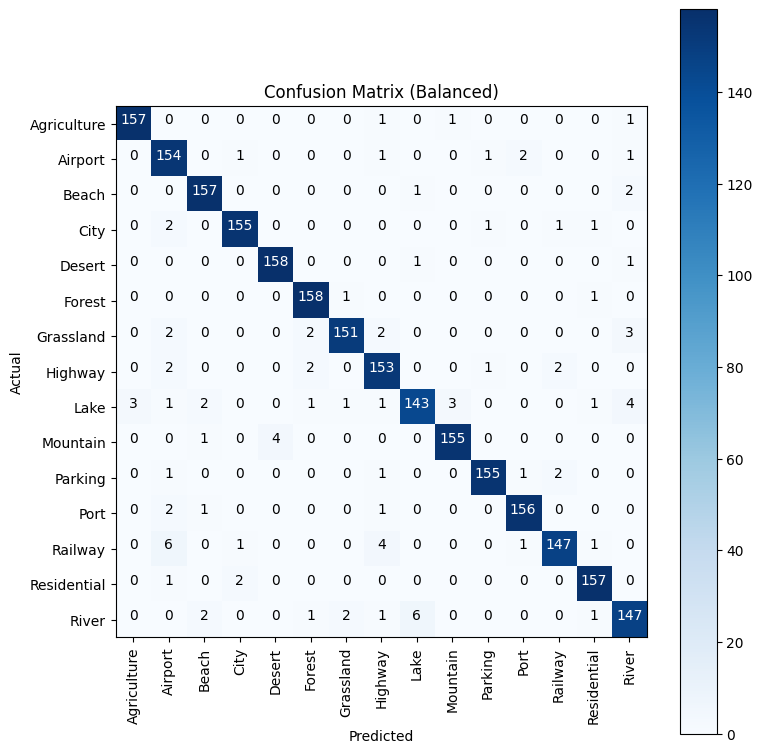

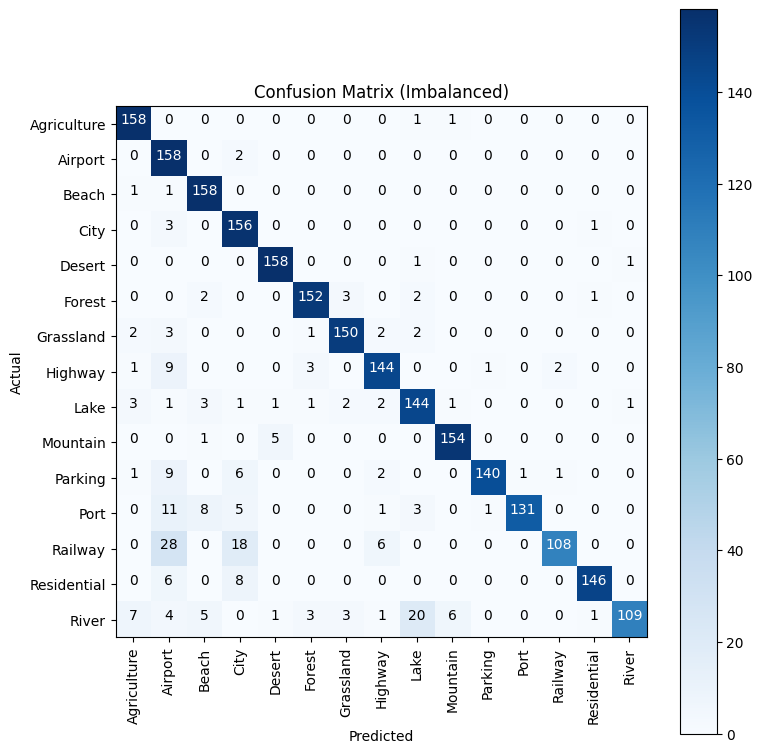

In [3]:
#!/usr/bin/env python3
"""
Hybrid SVM Classification on Aerial Landscapes
with Simulated Long-Tail Imbalance

Author:     Charissa Mao Jia Lau
Date:       2025-04-23
Course:     COMP9517 Computer Vision, UNSW

This script:
  1) Downloads the SkyView aerial landscape dataset via kagglehub
  2) Extracts three sets of features:
       • Local textures: SIFT → BoVW histogram
       • Semantic embeddings: SENet-50 → PCA (2048→128)
       • Global color: HSV histograms (8 bins × 3 channels)
  3) Concatenates these into a 352-dim vector per image
  4) Trains and evaluates an RBF-SVM under two regimes:
       A) Standard balanced split (80/20)
       B) Simulated long-tail imbalance (head/mid/tail)
  5) Prints classification reports and plots confusion matrices

Dependencies:
  Python 3.7+, OpenCV, scikit-learn, matplotlib, tqdm,
  kagglehub, timm, torch, torchvision, Pillow

Usage:
  pip install opencv-contrib-python scikit-learn matplotlib tqdm \
              kagglehub timm torch torchvision pillow
  python hybrid_svm_imbalanced.py
"""

import os
import random
import time
import gc
import logging

import numpy as np
import torch
import timm
import kagglehub
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm
from collections import defaultdict
from torchvision import transforms
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------------------------------------
# CONFIGURATION
# ------------------------------------------------------------------------------
random.seed(42)  # for reproducible splits and sampling
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------------------
# 1) Download & unpack dataset
# ------------------------------------------------------------------------------
dataset_root = kagglehub.dataset_download("ankit1743/skyview-an-aerial-landscape-dataset")
image_folder = os.path.join(dataset_root, "Aerial_Landscapes")
logging.info(f"Using dataset at: {image_folder}")

# ------------------------------------------------------------------------------
# 2) Build file list & label array
# ------------------------------------------------------------------------------
classes = sorted(os.listdir(image_folder))
image_paths = []
image_labels = []

for class_idx, class_name in enumerate(classes):
    class_dir = os.path.join(image_folder, class_name)
    for fname in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, fname))
        image_labels.append(class_idx)

logging.info(f"Found {len(classes)} classes, {len(image_paths)} images total.")

# ------------------------------------------------------------------------------
# 3) Split into train / test (80/20 stratified)
# ------------------------------------------------------------------------------
train_paths, test_paths, y_train, y_test = train_test_split(
    image_paths, image_labels,
    test_size=0.2,
    stratify=image_labels,
    random_state=42
)
logging.info(f"Train: {len(train_paths)} images, Test: {len(test_paths)} images")

# ------------------------------------------------------------------------------
# 4) Extract SIFT descriptors (for BoVW)
# ------------------------------------------------------------------------------
def extract_sift_descriptors(paths, phase_name):
    """Return a list of (N_kpts × 128) descriptor arrays for each image."""
    sift = cv2.SIFT_create()
    descriptors = []
    for p in tqdm(paths, desc=phase_name):
        gray = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        _, desc = sift.detectAndCompute(gray, None)
        if desc is None:
            desc = np.zeros((1, 128), dtype=np.float32)
        descriptors.append(desc)
    return descriptors

train_sift = extract_sift_descriptors(train_paths, "SIFT Train")
test_sift  = extract_sift_descriptors(test_paths,  "SIFT Test")

# ------------------------------------------------------------------------------
# 5) Build and apply BoVW (K=400)
# ------------------------------------------------------------------------------
VOCAB_SIZE = 200
all_descriptors = np.vstack(train_sift)
sample_indices  = np.random.choice(all_descriptors.shape[0], min(100_000, all_descriptors.shape[0]), replace=False)

kmeans = MiniBatchKMeans(n_clusters=VOCAB_SIZE, batch_size=VOCAB_SIZE*20, random_state=42)
kmeans.fit(all_descriptors[sample_indices])
del all_descriptors
gc.collect()

def compute_bovw_histogram(descriptor_list):
    """Assign each descriptor to nearest visual word and return L2-normalized histogram."""
    hist = np.bincount(kmeans.predict(descriptor_list), minlength=VOCAB_SIZE).astype(float)
    return hist / (np.linalg.norm(hist) + 1e-6)

X_train_bovw = np.vstack([compute_bovw_histogram(d) for d in tqdm(train_sift, desc="BoVW Train")])
X_test_bovw  = np.vstack([compute_bovw_histogram(d) for d in tqdm(test_sift,  desc="BoVW Test")])

# ------------------------------------------------------------------------------
# 6) SENet-50 embeddings → PCA to 128 dims
# ------------------------------------------------------------------------------
senet_model = timm.create_model('seresnet50', pretrained=True, num_classes=0).to(DEVICE).eval()
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def extract_senet_features(paths, phase_name):
    features = []
    with torch.no_grad():
        for p in tqdm(paths, desc=phase_name):
            img = Image.open(p).convert("RGB")
            inp = preprocess(img).unsqueeze(0).to(DEVICE)
            feat = senet_model(inp).view(-1).cpu().numpy()
            features.append(feat)
    return np.vstack(features)

train_senet = extract_senet_features(train_paths, "SENet Train")
test_senet  = extract_senet_features(test_paths,  "SENet Test")

pca = PCA(n_components=128, random_state=42)
X_train_senet = pca.fit_transform(train_senet)
X_test_senet  = pca.transform(test_senet)

# ------------------------------------------------------------------------------
# 7) HSV color histograms (8 bins per channel → 24 dims)
# ------------------------------------------------------------------------------
def extract_hsv_histogram(img_path, bins=8):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2HSV)
    hists = []
    for channel in cv2.split(img):
        hist, _ = np.histogram(channel, bins=bins, range=(0,256))
        hists.append(hist.astype(float) / (hist.sum() + 1e-6))
    return np.hstack(hists)

X_train_color = np.vstack([extract_hsv_histogram(p) for p in tqdm(train_paths, desc="Color Train")])
X_test_color  = np.vstack([extract_hsv_histogram(p) for p in tqdm(test_paths,  desc="Color Test")])

# ------------------------------------------------------------------------------
# 8) Concatenate all features into final vectors
# ------------------------------------------------------------------------------
X_train = np.hstack([X_train_bovw, X_train_senet, X_train_color])
X_test  = np.hstack([X_test_bovw,  X_test_senet,  X_test_color ])
logging.info(f"Feature vectors → Train: {X_train.shape}, Test: {X_test.shape}")

# ------------------------------------------------------------------------------
# 9) Simulate long-tail imbalance (head/mid/tail)
# ------------------------------------------------------------------------------
desired_counts = {
    **{cls: 640 for cls in range(5)},     # head
    **{cls: 200 for cls in range(5,10)},  # mid
    **{cls:  50 for cls in range(10,15)}  # tail
}

indices_by_class = defaultdict(list)
for idx, lbl in enumerate(y_train):
    indices_by_class[lbl].append(idx)

imbalanced_indices = []
for lbl, idx_list in indices_by_class.items():
    n_keep = min(desired_counts[lbl], len(idx_list))
    imbalanced_indices += random.sample(idx_list, n_keep)

X_train_imb = X_train[imbalanced_indices]
y_train_imb = [y_train[i] for i in imbalanced_indices]

logging.info(f"Balanced train size:   {len(y_train)}")
logging.info(f"Imbalanced train size: {len(y_train_imb)}")

# ------------------------------------------------------------------------------
# 10) Train & evaluate RBF-SVM on both regimes
# ------------------------------------------------------------------------------
classifier = SVC(C=12, gamma=0.04, kernel='rbf', random_state=42)

# — balanced —
start = time.time()
classifier.fit(X_train, y_train)
y_pred_bal = classifier.predict(X_test)
acc_bal = classifier.score(X_test, y_test)
logging.info(f"Balanced accuracy = {acc_bal:.4f} (time {time.time()-start:.1f}s)")

# — imbalanced —
start = time.time()
classifier.fit(X_train_imb, y_train_imb)
y_pred_imb = classifier.predict(X_test)
acc_imb = classifier.score(X_test, y_test)
logging.info(f"Imbalanced accuracy = {acc_imb:.4f} (time {time.time()-start:.1f}s)\n")


# ------------------------------------------------------------------------------
# 11) Reports & confusion matrices
# ------------------------------------------------------------------------------
# — balanced —
t0 = time.time()
classifier.fit(X_train, y_train)
y_pred_bal = classifier.predict(X_test)
acc_bal    = classifier.score(X_test, y_test)
print(f"\n>>> Balanced Test Accuracy: {acc_bal:.4f} (train+eval {time.time()-t0:.1f}s)")

# — imbalanced —
t1 = time.time()
classifier.fit(X_train_imb, y_train_imb)
y_pred_imb = classifier.predict(X_test)
acc_imb    = classifier.score(X_test, y_test)
print(f">>> Imbalanced Test Accuracy: {acc_imb:.4f} (train+eval {time.time()-t1:.1f}s)\n")

print("=== Balanced Dataset Classification Report ===")
print(classification_report(y_test, y_pred_bal, target_names=classes))

print("=== Imbalanced Dataset Classification Report ===")
print(classification_report(y_test, y_pred_imb, target_names=classes))

for preds, title in zip([y_pred_bal, y_pred_imb], ["Balanced", "Imbalanced"]):
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(8,8))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"Confusion Matrix ({title})")
    plt.colorbar()
    plt.xticks(range(len(classes)), classes, rotation=90)
    plt.yticks(range(len(classes)), classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, cm[i,j],
                     ha='center',
                     color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()